In [1]:
import sys
import warnings
sys.path.insert(0, "..")
warnings.filterwarnings("ignore")

import gpflow
import numpy as np
import tensorflow as tf

from osvgp.datasets import load_snelson
from osvgp.models import OSGPR
from osvgp.plotting import plot_dataset_1D, plot_predictions_1D

In [2]:
# Fix random states
tf.random.set_seed(69)
rng = np.random.RandomState(69)

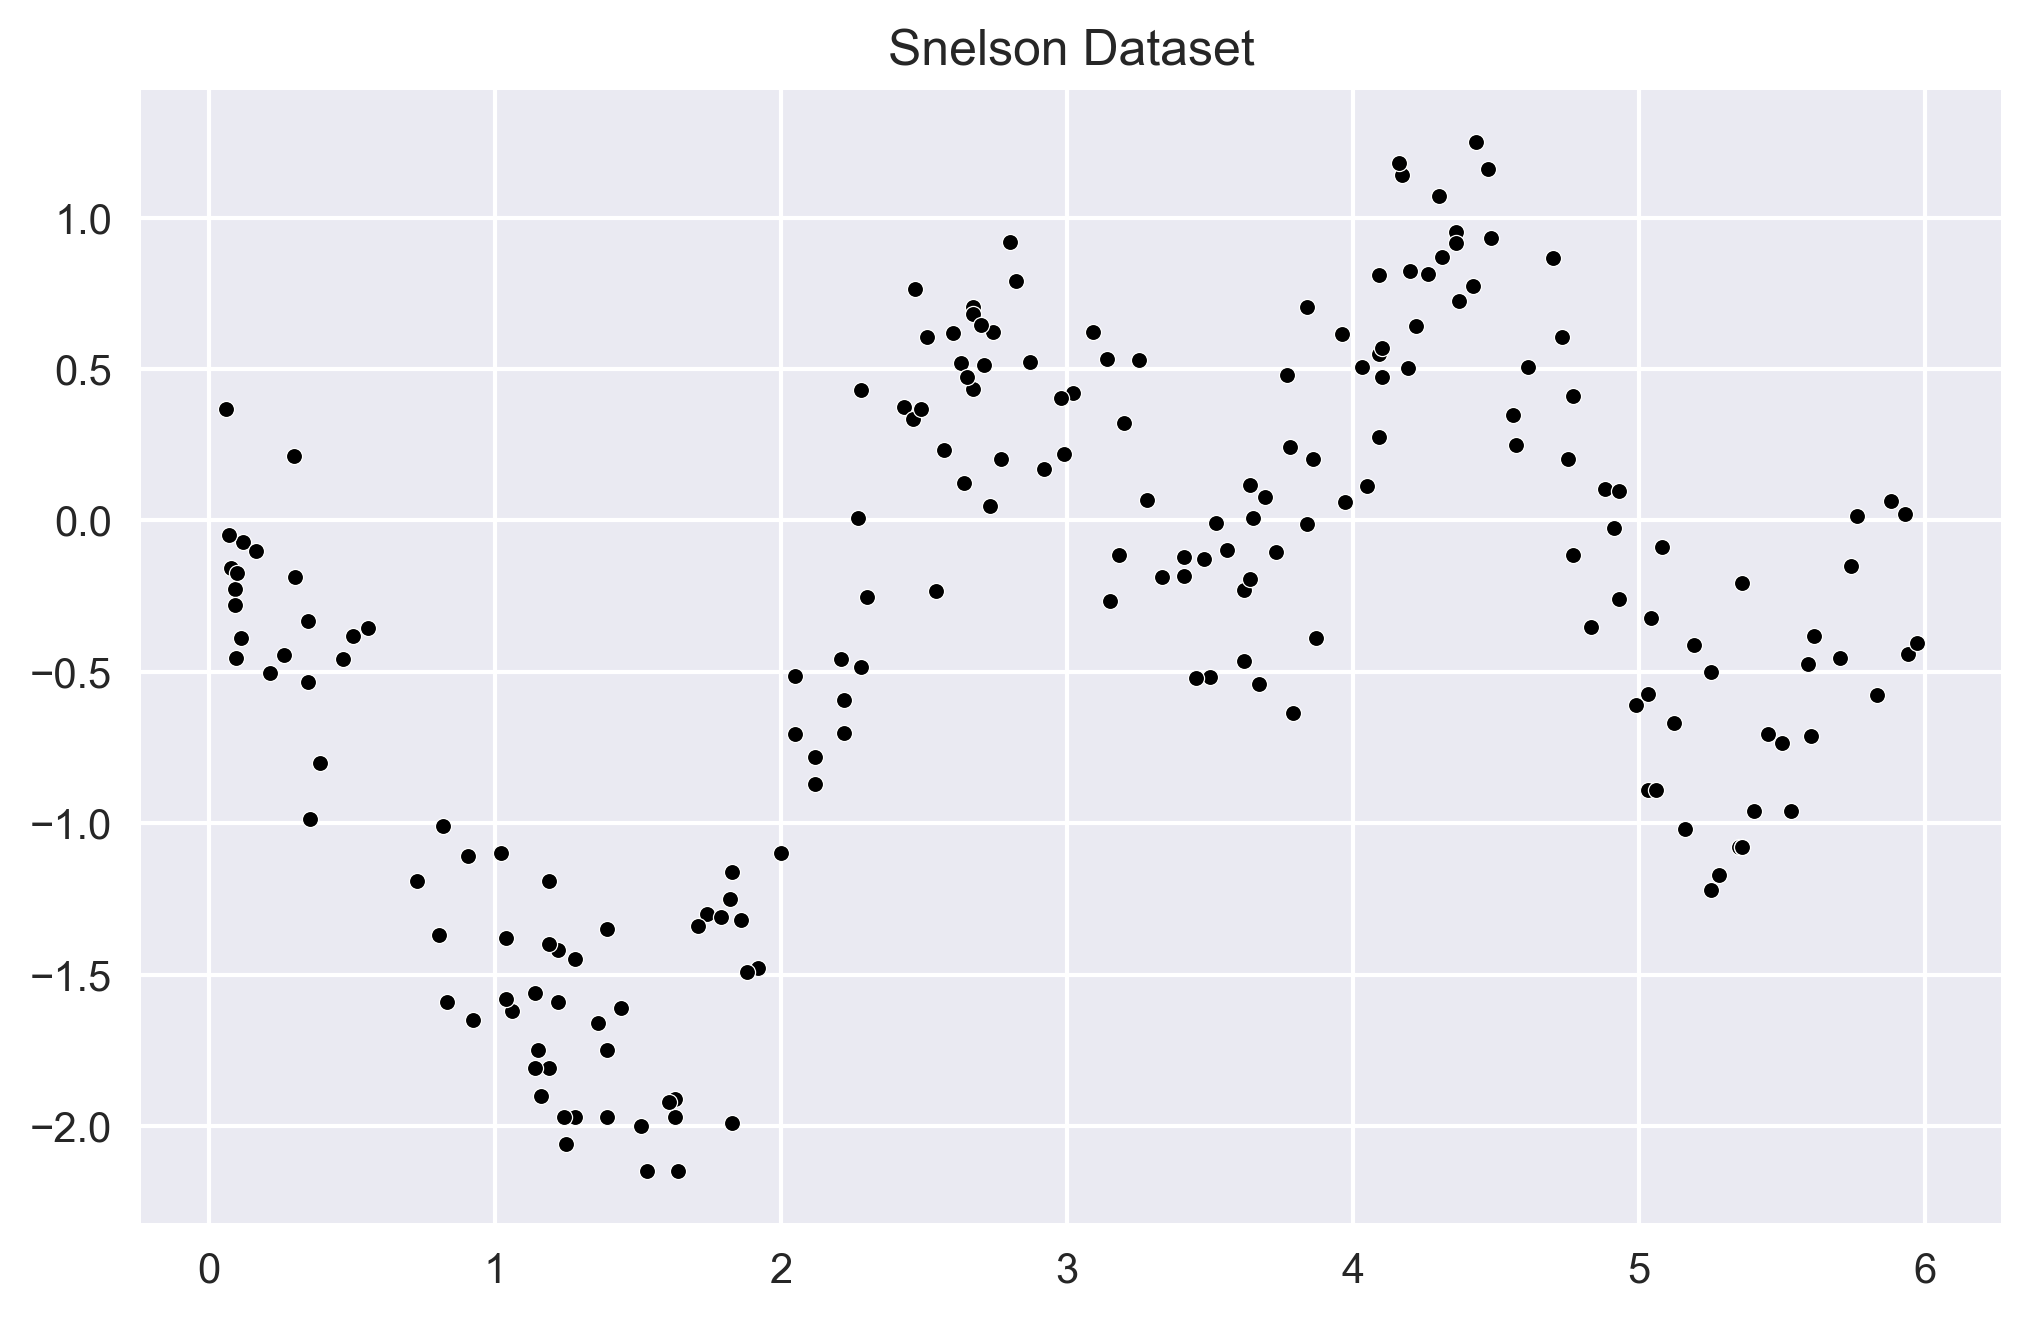

In [3]:
# Load Snelson dataset
X, y = load_snelson()
data = (X, y)

# Number of training observations and noise scale
N = X.shape[0]
noise_variance = 0.25 ** 2

# Generate plot
plot_dataset_1D(data, title="Snelson Dataset")

In [11]:
# Initialise inducing points
Mu, Mv = 10, 10
Z, O = rng.rand(Mu, 1) * 6, rng.rand(Mv, 1) * 6
inducing_inputs = (Z, O)

# Set kernel
kernel = gpflow.kernels.SquaredExponential()

# Initialise the SGPR models
odvgp = OSGPR(data, kernel, inducing_inputs, noise_variance, "ODVGP")
solvegp = OSGPR(data, kernel, inducing_inputs, noise_variance, "SOLVE-GP")

In [12]:
# L-BFGS optimiser
optimiser = gpflow.optimizers.Scipy()

# Optimise ODVGP model
optimiser.minimize(odvgp.training_loss, 
                   odvgp.trainable_variables,
                   options={"maxiter": 1000, "disp": False})

# Optimise SOLVE-GP model
optimiser.minimize(solvegp.training_loss, 
                   solvegp.trainable_variables,
                   options={"maxiter": 1000, "disp": False})             

      fun: 56.001472871065474
 hess_inv: <23x23 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.45883879e-05, -2.10566524e-05, -4.01012263e-05, -2.64794125e-05,
        1.97172982e-04,  3.16203830e-05, -1.11617946e-04,  2.11591876e-05,
       -1.85132327e-04, -1.31474035e-04,  3.47745041e-06,  2.80602975e-05,
        1.05716972e-04, -4.83296761e-05,  4.56499464e-06,  5.72110432e-05,
       -7.56571883e-05,  5.35933029e-06,  7.00259711e-07, -5.50943868e-05,
        2.75759663e-04, -1.94547684e-04, -3.51702605e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 126
      nit: 115
     njev: 126
   status: 0
  success: True
        x: array([ 0.87158428,  3.14878683,  0.4363696 ,  5.40326084,  5.95640513,
        1.61559252,  5.05439834,  1.96017134,  5.73628326,  1.21630789,
        4.06260738,  2.79610592,  2.31777432,  3.48219836,  3.75726217,
        0.17599492,  2.55346695,  4.70775879,  0.0503819 ,  4.33573749,
       -0.1701363 ,  0.14456956, 

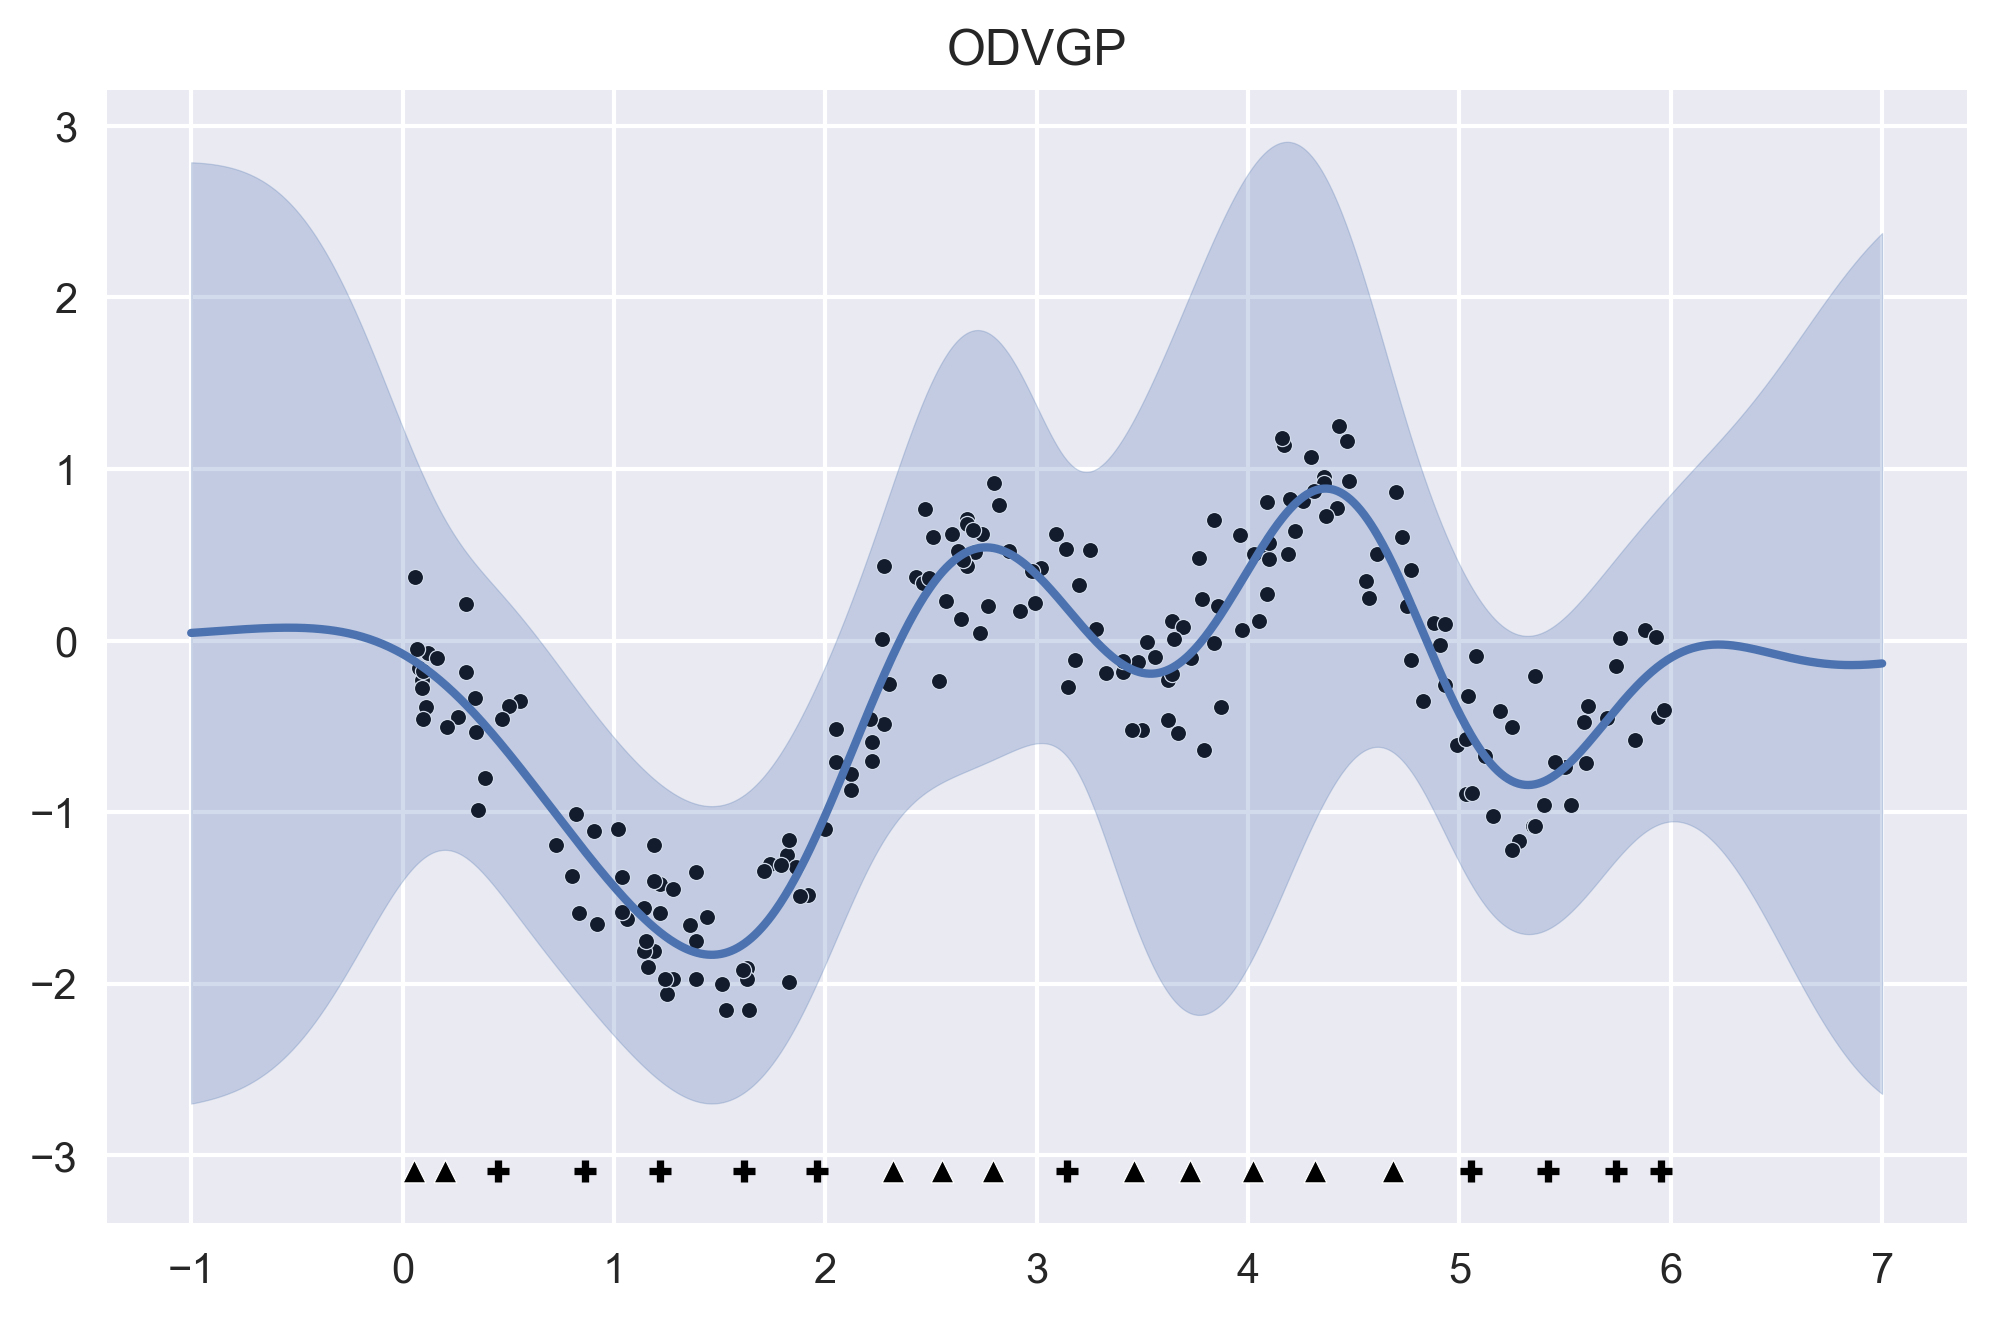

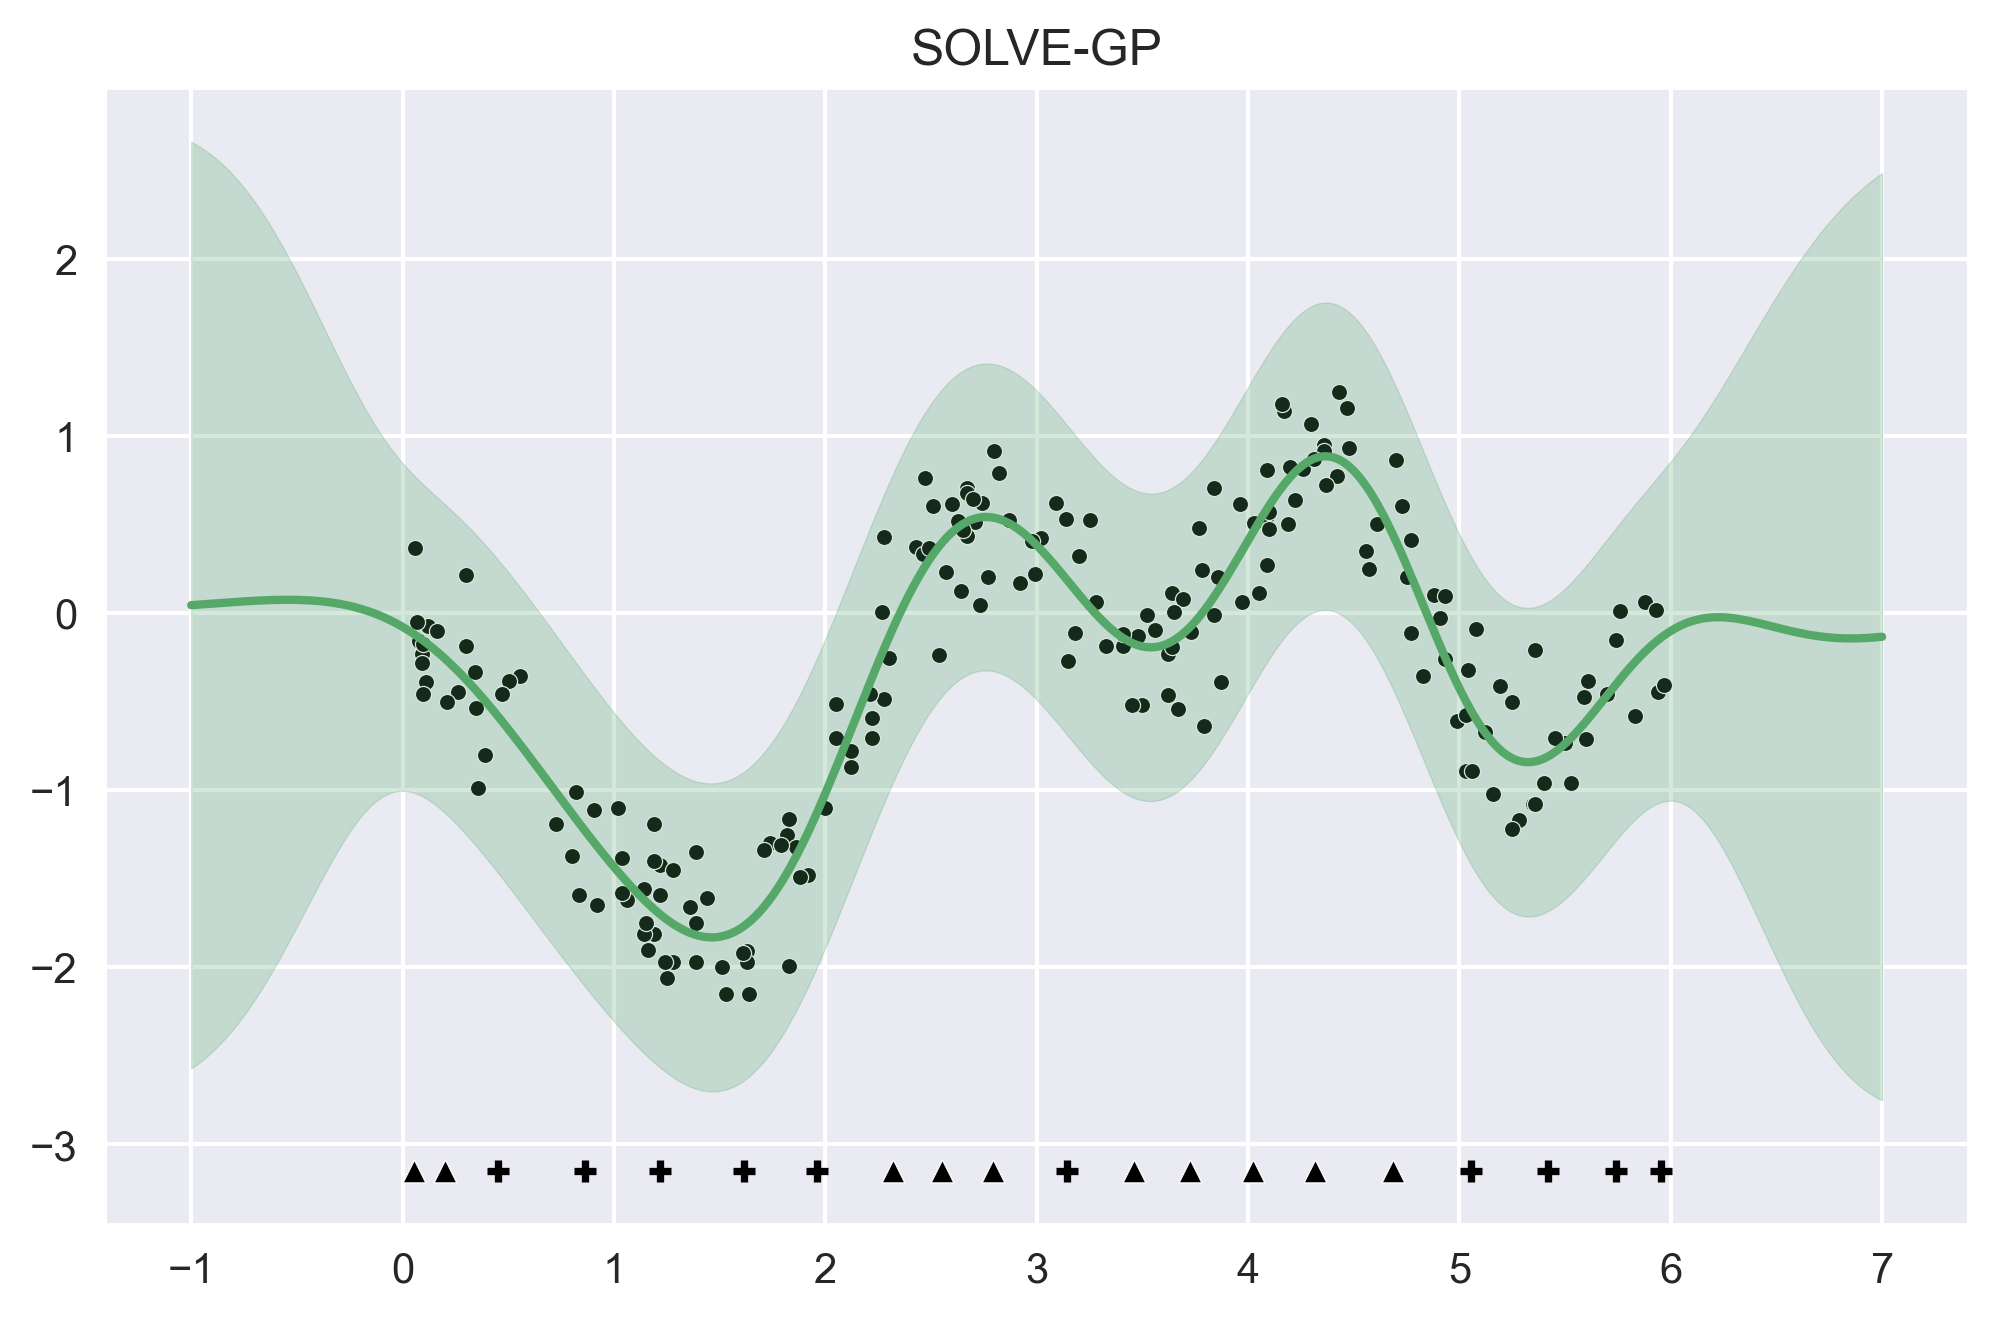

In [13]:
# New points at which to predict the latent function
Xnew = np.linspace(-1.0, 7.0, 1000).reshape(-1, 1)

# ODVGP predictions
odvgp_mean, odvgp_var = odvgp.predict_y(Xnew)
odvgp_preds = (Xnew, odvgp_mean, odvgp_var)
odvgp_iv = (odvgp.Z, odvgp.O)

# SOLVE-GP predictions
solvegp_mean,  solvegp_var = solvegp.predict_y(Xnew)
solvegp_preds = (Xnew, solvegp_mean, solvegp_var)
solvegp_iv = (solvegp.Z, solvegp.O)

# Generate plots
plot_predictions_1D(data, odvgp_preds, odvgp_iv, c="C0", title="ODVGP")
plot_predictions_1D(data, solvegp_preds, odvgp_iv, c="C1", title="SOLVE-GP")

In [ ]:
# # Variational parameters
# Z, O = solve_gp.Z, solve_gp.O
# mu, mv = solve_gp.mu, solve_gp.mv
# Su, Sv = solve_gp.Su, solve_gp.Sv

# # Generate plot
# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# ax.scatter(X, y, facecolor="k", edgecolor="w", s=10, alpha=0.8, 
#            marker="^",label="Observations")
# ax.scatter(Z, mu, facecolor="C0", edgecolor="w", s=30, label="u=f(Z)")
# ax.scatter(O, mv, facecolor="C1", edgecolor="w", s=30, label="v=f(O)")
# ax.set_title("Variational Parameters")
# ax.legend()
# plt.show()